# Best practices


## Use @cell decorator

- Do not name leave cells Unnamed.


Unnamed cells are going to get different names every time you run and is going to be hard to know where they come from.

In [1]:
import gdsfactory as gf

c = gf.Component()
print(c.name)

Unnamed_0


- Do not name cells manually. Manually defining names can create duplicated cells.

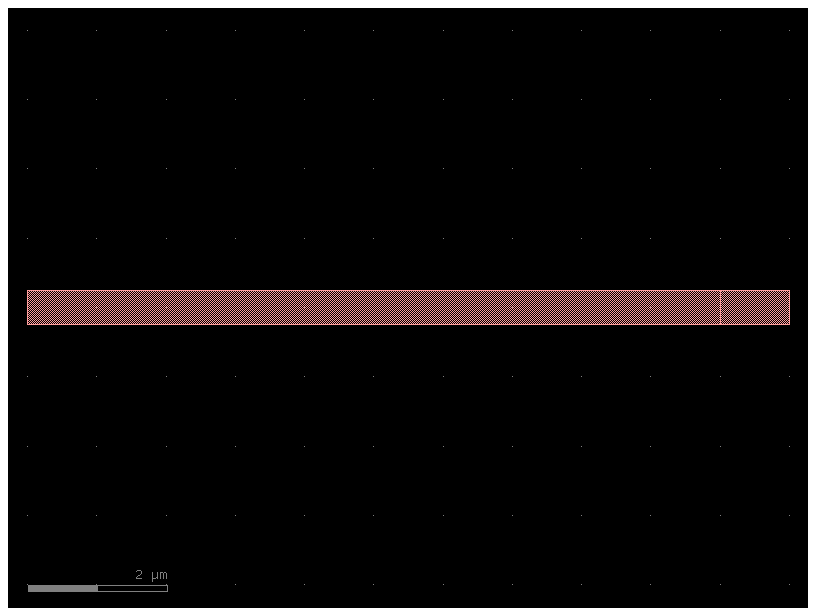

In [2]:
c1 = gf.Component("my_cell1")
c2 = gf.Component("my_cell2")
c1.add_ref(gf.components.straight(length=10))
c2.add_ref(gf.components.straight(length=11))

c3 = gf.Component("im_going_to_have_duplicated_cell_names")
_ = c3.add_ref(c1)
_ = c3.add_ref(c2)
c3.plot()

Solution: Use the cell decorator to name cells

In [3]:
@gf.cell
def my_pcell(length=10):
    c = gf.Component()
    ref = c1.add_ref(gf.components.straight(length=length))
    c.add_ports(ref.ports)
    return c


print(my_pcell(length=11).name)
print(my_pcell(length=12).name)

my_pcell_L11
my_pcell_L12


## Keep cell functions simple

As you make functions made of other functions one can start passing a lot of arguments to the function. This makes the code hard to write, read and maintain.

- Avoid complicated functions with many parameters


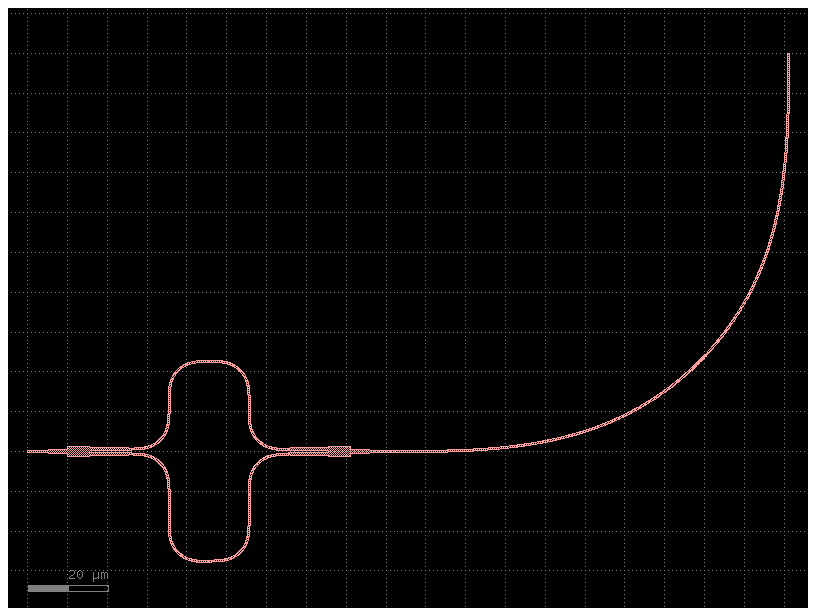

In [4]:
@gf.cell
def mzi_with_bend_overly_complicated(
    mzi_delta_length: float = 10.0,
    mzi_length_y: float = 2.0,
    mzi_length_x: float | None = 0.1,
    bend_radius: float = 10,
    bend_cross_section="strip",
):
    """Returns MZI interferometer with bend."""
    c = gf.Component()
    mzi1 = c.add_ref(
        gf.components.mzi(
            delta_length=mzi_delta_length,
            length_y=mzi_length_y,
            length_x=mzi_length_x,
        )
    )
    bend1 = c.add_ref(
        gf.components.bend_euler(radius=bend_radius, cross_section=bend_cross_section)
    )
    bend1.connect("o1", mzi1.ports["o2"])
    c.add_port("o1", port=mzi1.ports["o1"])
    c.add_port("o2", port=bend1.ports["o2"])
    return c


c = mzi_with_bend_overly_complicated(bend_radius=100)
c.plot()

Solution:

- leverage `functools.partial` to customize the default parameters of a function

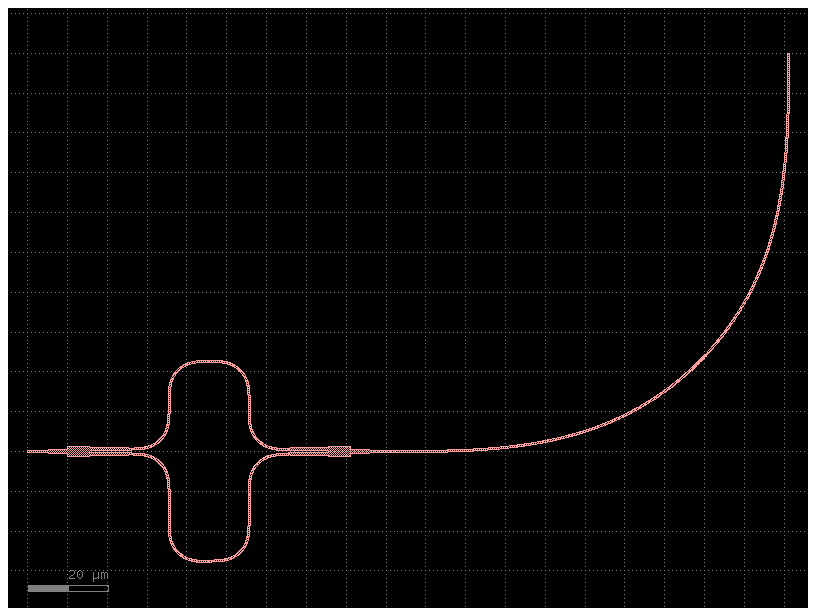

In [5]:
from functools import partial


@gf.cell
def mzi_with_bend(mzi=gf.components.mzi, bend=gf.components.bend_euler):
    """Returns MZI interferometer with bend."""
    c = gf.Component()
    mzi1 = c.add_ref(mzi())
    bend1 = c.add_ref(bend())
    bend1.connect("o1", mzi1.ports["o2"])
    c.add_port("o1", port=mzi1.ports["o1"])
    c.add_port("o2", port=bend1.ports["o2"])
    return c


bend_big = partial(gf.components.bend_euler, radius=100)
c = mzi_with_bend(bend=bend_big)
c.plot()

## Use array of references

- Array of references are more memory efficient and faster to create

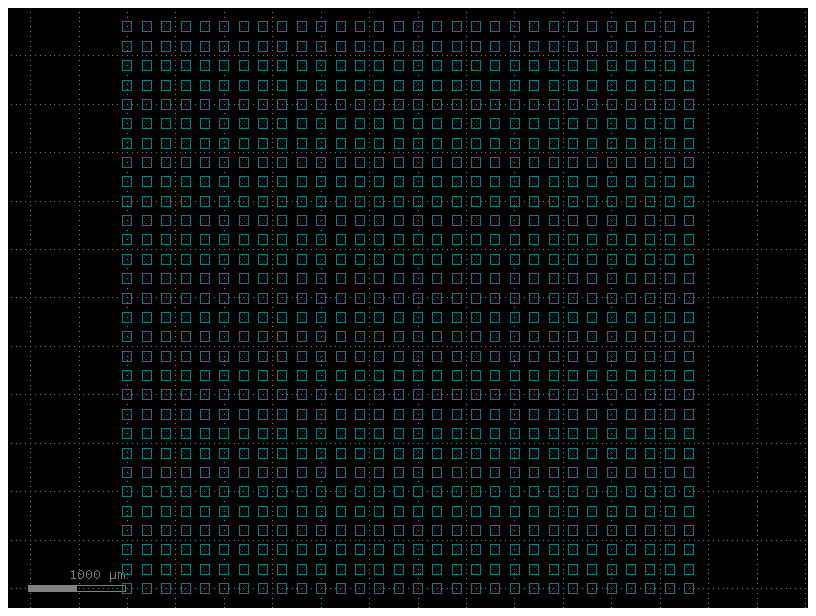

In [6]:
@gf.cell
def pad_array_slow(
    cols: int = 30,
    rows: int = 30,
    spacing: tuple[float, float] = (200, 200),
    pad=gf.components.pad,
):
    """Returns a grid of pads. BAD CODE. DO NOT USE."""
    xspacing, yspacing = spacing
    c = gf.Component()
    for col in range(cols):
        for row in range(rows):
            c.add_ref(pad()).dmovex(col * xspacing).dmovey(row * yspacing)
    return c


c = pad_array_slow()
c.plot()

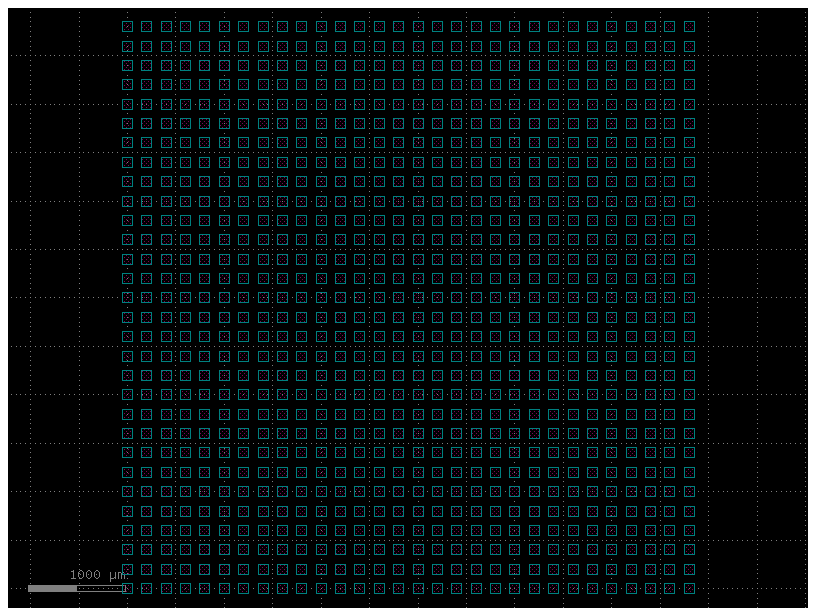

In [9]:
@gf.cell
def pad_array_fast(
    cols: int = 30,
    rows: int = 30,
    col_spacing: float = 200,
    row_spacing: float = 200,
    pad=gf.components.pad,
):
    """Returns a grid of pads. GOOD CODE. USE THIS."""
    c = gf.Component()
    c.add_ref(pad(), columns=cols, rows=rows, column_pitch=col_spacing, row_pitch=row_spacing)
    return c


c = pad_array_fast()
c.plot()